## Registration method - Deformation Field

Author: Felipe Cortes Jaramillo

Date: 11 November, 2023

For this method we register different images from lasers using a method inspired in VoxelMorph alrgorithm: https://github.com/voxelmorph/voxelmorph

In [ ]:
# First, we are going to download the library
!pip install voxelmorph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystrum: filename=pystrum-0.4-py3-none-any.whl size=19532 sha256=73a1d6e6c90a05895aa0a387d4716e0a2b26cec7463c749f791b340ead7ef319
  Stored in directory: /root/.cache/pip/wheels/aa/08/d0/914025beb5a12a855b8aafd22eeedc547198684a3f4409f66c
Successfully built pystrum


In [ ]:
# Importing dependencies
import os, sys, shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import tqdm
from PIL import Image
import glob
assert tf.__version__.startswith('2.'), 'This requires Tensorflow 2.0+'

# Importing special dependencies
import voxelmorph as vxm
import neurite as ne

In [ ]:
# We mount Colab for this
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data adquisiton - Pre-processing
We download the data and apply some simple pre-processing!

In [ ]:
# Let's load the data
cut_number = 4
images_route_24_30 = f'./drive/MyDrive/24_30/cut_{cut_number}/'
images_route_22_30 = f'./drive/MyDrive/22_30/cut_{cut_number}/'
images_route_20_2  = f'./drive/MyDrive/20_2/cut_{cut_number}/'

filelist_24_30  = sorted(glob.glob(f'{images_route_24_30}*.jpg'))
filelist_22_30 = sorted(glob.glob(f'{images_route_22_30}*.jpg'))
filelist_20_2 = sorted(glob.glob(f'{images_route_20_2}*.jpg'))

data_set_24_30 = np.array([np.array(Image.open(fname).convert('L')) for fname in filelist_24_30])
data_set_22_30 = np.array([np.array(Image.open(fname).convert('L')) for fname in filelist_22_30])
data_set_20_2 = np.array([np.array(Image.open(fname).convert('L')) for fname in filelist_20_2])


# Print shapes
print(f"Shape of data 24_30 set: {data_set_24_30.shape}")
print(f"Shape of data 22_30 set: {data_set_22_30.shape}")
print(f"Shape of data 20_2 set: {data_set_20_2.shape}")

Shape of data 24_30 set: (50, 960, 960)
Shape of data 22_30 set: (50, 960, 960)
Shape of data 20_2 set: (50, 960, 960)


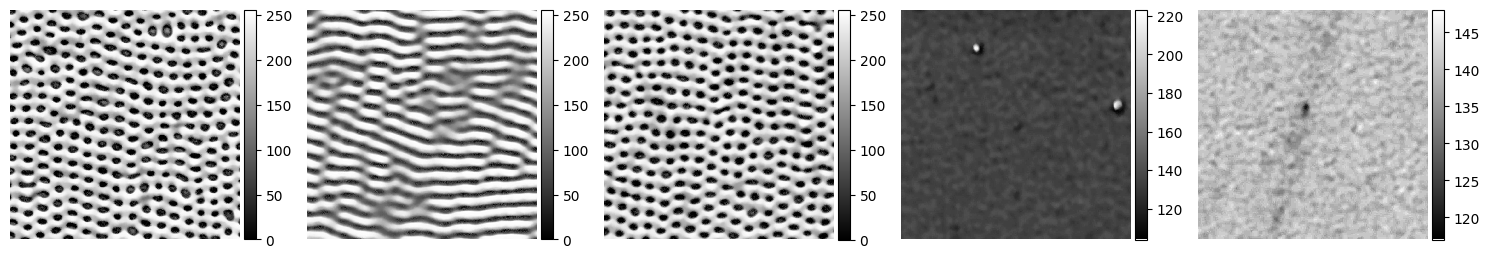

In [ ]:
# We can visualize some of the data from the first set

nb_vis = 5
# choose nb_vis sample indexes
idx = np.random.choice(data_set_24_30.shape[0], nb_vis, replace=False)
example_digits = [f for f in data_set_24_30[idx, ...]]

# plot
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

In [ ]:
# We normalize the data to be in range [0 - 1]
norm_data_set_24_30 = data_set_24_30.astype('float')/255
norm_data_set_22_30 = data_set_22_30.astype('float')/255
norm_data_set_20_2  = data_set_20_2.astype('float')/255

# Verify
print('Set of 24_30 maximum value', norm_data_set_24_30.max())
print('Set of 22_30 maximum value', norm_data_set_22_30.max())
print('Set of 20_2 maximum value', norm_data_set_20_2.max())

Set of 24_30 maximum value 1.0
Set of 22_30 maximum value 1.0
Set of 20_2 maximum value 1.0


In [ ]:
# We can add optionally a padding if we want to achieve a desired shape
#pad_amount = ((0, 0), (16,16), (16,16))
pad_amount = ((0, 0), (0, 0), (0, 0))

# fix data
x_24_30 = np.pad(norm_data_set_24_30, pad_amount, 'constant')
x_22_30 = np.pad(norm_data_set_22_30, pad_amount, 'constant')
x_20_2  = np.pad(norm_data_set_20_2, pad_amount, 'constant')

# verify
print('Shape of 24_30 training data', x_24_30.shape)
print('Shape of 22_30 training data', x_22_30.shape)
print('Shape of 20_2 training data', x_20_2.shape)


Shape of 24_30 training data (50, 960, 960)
Shape of 22_30 training data (50, 960, 960)
Shape of 20_2 training data (50, 960, 960)


In [ ]:
# --- Training the model - Random Generator ---

def vxm_data_generator(x_data, batch_size=2):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)

    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]

        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare
        # the resulting moved image with the fixed image.
        # we also wish to penalize the deformation field.
        outputs = [fixed_images, zero_phi]

        yield (inputs, outputs)

In [ ]:
# --- Training the model - Sequenced Generator ---

def vxm_data_seq_generator(x_data, batch_size=2):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    amount_data = x_data.shape[0]

    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0]-1, size=batch_size)
        fixed_images = x_data[idx1, ..., np.newaxis]
        idx2_temp = []
        for i in range(len(idx1)):
          if idx1[i] == amount_data-1:
            idx1[i] -= 2
            idx2_temp.append(idx1[i]-1)
          else:
            idx2_temp.append(idx1[i] + 1)
        idx2_temp = np.array(idx2_temp)
        moving_images = x_data[idx2_temp, ..., np.newaxis]
        inputs = [moving_images, fixed_images]

        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare
        # the resulting moved image with the fixed image.
        # we also wish to penalize the deformation field.
        outputs = [fixed_images, zero_phi]

        yield (inputs, outputs)

In [ ]:
# We create the data generators
train_rnd_generator_24_30 = vxm_data_generator(x_24_30)
train_rnd_generator_22_30 = vxm_data_generator(x_22_30)
train_rnd_generator_20_2  = vxm_data_generator(x_20_2)

In [ ]:
# We create the data generators
train_generator_24_30 = vxm_data_seq_generator(x_24_30)
train_generator_22_30 = vxm_data_seq_generator(x_22_30)
train_generator_20_2  = vxm_data_seq_generator(x_20_2)

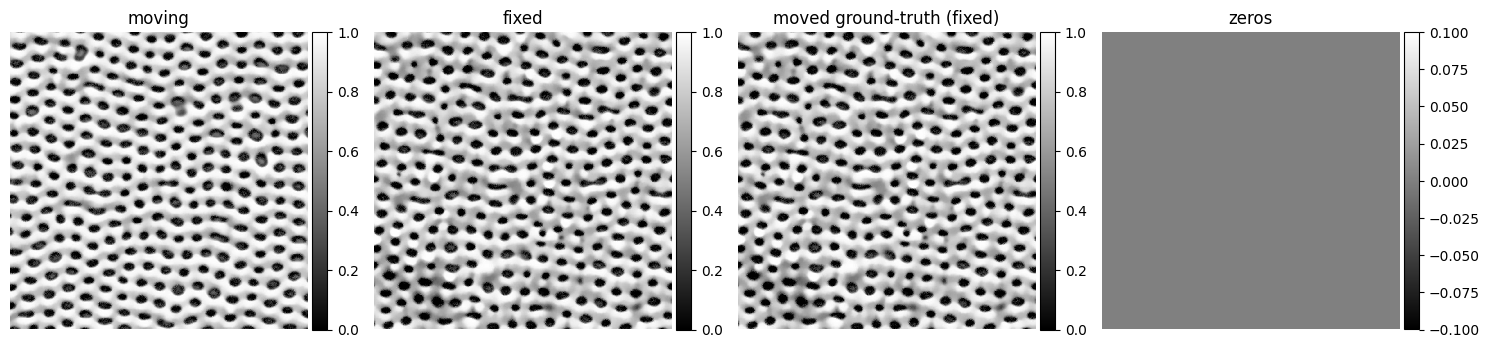

In [ ]:
# We can test one of them
in_seq_sample, out_seq_sample = next(train_generator_24_30)

# visualize
images = [img[0, :, :, 0] for img in in_seq_sample + out_seq_sample]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

### Model definition - Support functions
We define the main model and some funtions that will help in the training!

In [ ]:
def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
# First, configure unet input shape (concatenation of moving and fixed images).
nb_features = [
    [64, 128, 256],         # encoder features
    [256, 256, 256, 16]     # decoder features
]

# Let's create model with library
inshape_24_30 = x_24_30.shape[1:]
inshape_22_30 = x_22_30.shape[1:]
inshape_20_2 = x_20_2.shape[1:]
vxm_model_24_30 = vxm.networks.VxmDense(inshape_24_30, nb_features, int_steps=0)
vxm_model_22_30 = vxm.networks.VxmDense(inshape_22_30, nb_features, int_steps=0)
vxm_model_20_2 = vxm.networks.VxmDense(inshape_20_2, nb_features, int_steps=0)

In [ ]:
# Define loss and lambda for the losses (hyper-parameter)
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]
lambda_param = 0.015
loss_weights = [1, lambda_param]
opt1 = tf.keras.optimizers.Adam(learning_rate=1e-4)
opt2 = tf.keras.optimizers.Adam(learning_rate=1e-4)
opt3 = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [ ]:
# We compile the model
vxm_model_24_30.compile(optimizer=opt1, loss=losses, loss_weights=loss_weights)
vxm_model_22_30.compile(optimizer=opt2, loss=losses, loss_weights=loss_weights)
vxm_model_20_2.compile(optimizer=opt3, loss=losses, loss_weights=loss_weights)

### Model Training
We train the model with the different datasets.

In [ ]:
# We define the epochs and steps
nb_epochs = 5
steps_per_epoch = 100

Epoch 1/5
100/100 - 153s - loss: 0.0228 - vxm_dense_transformer_loss: 0.0149 - vxm_dense_flow_loss: 0.5274 - 153s/epoch - 2s/step
Epoch 2/5
100/100 - 116s - loss: 0.0204 - vxm_dense_transformer_loss: 0.0132 - vxm_dense_flow_loss: 0.4827 - 116s/epoch - 1s/step
Epoch 3/5
100/100 - 115s - loss: 0.0205 - vxm_dense_transformer_loss: 0.0131 - vxm_dense_flow_loss: 0.4898 - 115s/epoch - 1s/step
Epoch 4/5
100/100 - 116s - loss: 0.0222 - vxm_dense_transformer_loss: 0.0142 - vxm_dense_flow_loss: 0.5337 - 116s/epoch - 1s/step
Epoch 5/5
100/100 - 116s - loss: 0.0212 - vxm_dense_transformer_loss: 0.0136 - vxm_dense_flow_loss: 0.5035 - 116s/epoch - 1s/step


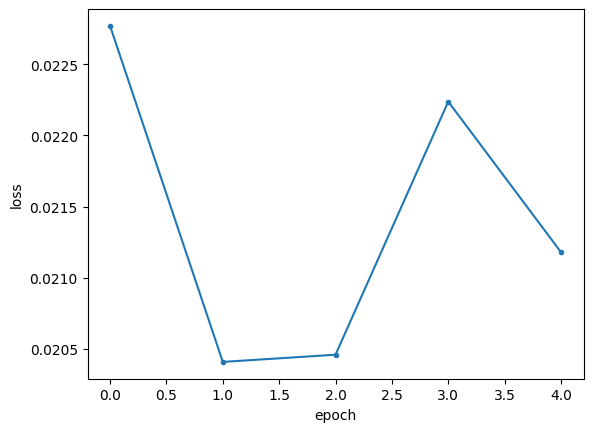

In [ ]:
# First, with the laset 24_30 dataset
vxm_model_24_30.load_weights(f'./drive/MyDrive/result_sink/24_30_registered/24_30_c1_weights.h5')
hist_24_30 = vxm_model_24_30.fit(train_generator_24_30, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2)
plot_history(hist_24_30)
np.mean(hist_24_30.history['loss'])
vxm_model_24_30.save_weights(f'./drive/MyDrive/result_sink/24_30_registered/24_30_c{cut_number}_weights.h5')

Epoch 1/5
100/100 - 119s - loss: 0.0228 - vxm_dense_transformer_loss: 0.0169 - vxm_dense_flow_loss: 0.3935 - 119s/epoch - 1s/step
Epoch 2/5
100/100 - 116s - loss: 0.0221 - vxm_dense_transformer_loss: 0.0169 - vxm_dense_flow_loss: 0.3464 - 116s/epoch - 1s/step
Epoch 3/5
100/100 - 116s - loss: 0.0236 - vxm_dense_transformer_loss: 0.0172 - vxm_dense_flow_loss: 0.4249 - 116s/epoch - 1s/step
Epoch 4/5
100/100 - 116s - loss: 0.0230 - vxm_dense_transformer_loss: 0.0172 - vxm_dense_flow_loss: 0.3862 - 116s/epoch - 1s/step
Epoch 5/5
100/100 - 116s - loss: 0.0231 - vxm_dense_transformer_loss: 0.0172 - vxm_dense_flow_loss: 0.3941 - 116s/epoch - 1s/step


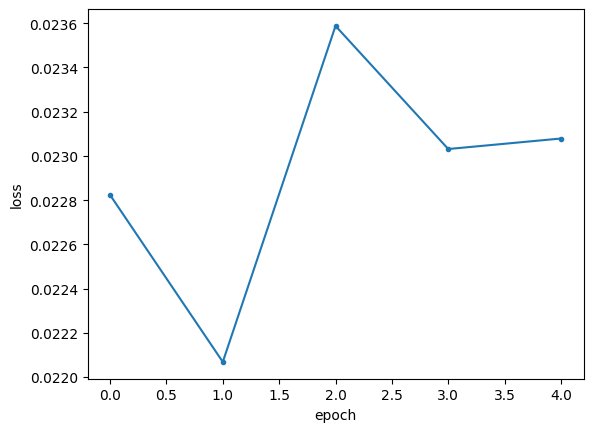

In [ ]:
# Second, with the laset 22_30 dataset
vxm_model_22_30.load_weights(f'./drive/MyDrive/result_sink/22_30_registered/22_30_c1_weights.h5')
hist_22_30 = vxm_model_22_30.fit(train_generator_22_30, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2)
plot_history(hist_22_30)
np.mean(hist_22_30.history['loss'])
vxm_model_22_30.save_weights(f'./drive/MyDrive/result_sink/22_30_registered/22_30_c{cut_number}_weights.h5')

Epoch 1/5
100/100 - 119s - loss: 0.0104 - vxm_dense_transformer_loss: 0.0074 - vxm_dense_flow_loss: 0.2049 - 119s/epoch - 1s/step
Epoch 2/5
100/100 - 115s - loss: 0.0104 - vxm_dense_transformer_loss: 0.0074 - vxm_dense_flow_loss: 0.2036 - 115s/epoch - 1s/step
Epoch 3/5
100/100 - 115s - loss: 0.0096 - vxm_dense_transformer_loss: 0.0066 - vxm_dense_flow_loss: 0.1974 - 115s/epoch - 1s/step
Epoch 4/5
100/100 - 116s - loss: 0.0106 - vxm_dense_transformer_loss: 0.0073 - vxm_dense_flow_loss: 0.2170 - 116s/epoch - 1s/step
Epoch 5/5
100/100 - 116s - loss: 0.0105 - vxm_dense_transformer_loss: 0.0073 - vxm_dense_flow_loss: 0.2112 - 116s/epoch - 1s/step


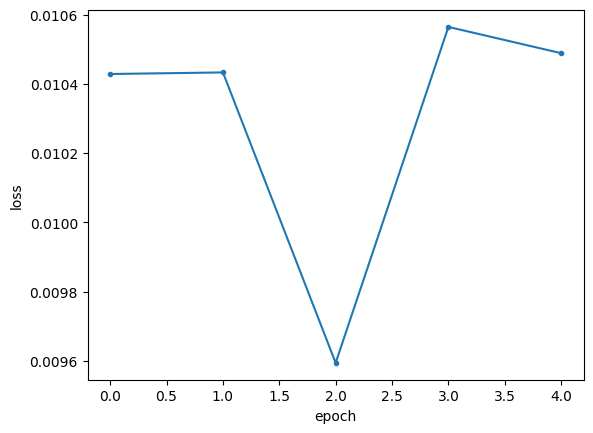

In [ ]:
# Finally, with the laset 20_2 dataset
vxm_model_20_2.load_weights(f'./drive/MyDrive/result_sink/20_2_registered/20_2_c1_weights.h5')
hist_20_2 = vxm_model_20_2.fit(train_generator_20_2, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2)
plot_history(hist_20_2)
np.mean(hist_20_2.history['loss'])
vxm_model_20_2.save_weights(f'./drive/MyDrive/result_sink/20_2_registered/20_2_c{cut_number}_weights.h5')

### Model Prediction
We define do the sequential prediction and save all the results!

In [ ]:
def prediction_convert_image(prediction, save_route, id):
    I = prediction[0].squeeze(2)
    I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)
    img = Image.fromarray(I8)
    img.save(f"{save_route}images/registered_{id}.jpg")

In [ ]:
def flow_convert_image(flow, save_route, id):
  I_flow = flow[0, :, :, 0]
  I8_flow = (((I_flow - I_flow.min()) / (I_flow.max() - I_flow.min())) * 255.9).astype(np.uint8)
  img = Image.fromarray(I8_flow)
  img.save(f"{save_route}flow/flow_{id}.jpg")

In [ ]:
def calculate_psnr(img1, img2, max_value=255):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

In [ ]:
def metrics_image(results, res = 224):
  image_resuls = []
  for res in results:
    I = res[0].squeeze(2)
    I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)
    img = Image.fromarray(I8)
    image_resuls.append(I8)

  features = np.stack(image_resuls, axis=0)

  ssim_across = []
  psnr_across = []
  for i in range(len(features) - 1):
    fixed_image = np.expand_dims(features[i], -1)
    next_image = np.expand_dims(features[i+1], -1)
    ssim_skimg = ssim(fixed_image, next_image, channel_axis=-1, data_range=255)
    psnr_skimg = calculate_psnr(fixed_image, next_image)
    ssim_across.append(ssim_skimg)
    psnr_across.append(psnr_skimg)

  print(f"Average SSIM in the raw data: {round(np.mean(ssim_across), 4)}")
  print(f"Average PSNR in the raw data: {round(np.mean(psnr_across), 4)}")

In [ ]:
# - Finally - Let's do the procedure to predict sequentially the data

def sequential_registration(x_data, model, save_route, batch_size=1):
    # preliminary sizing
    amount_data = x_data.shape[0]

    # We predict the first image
    fixed_image = x_data[np.array([0]), ..., np.newaxis]
    moving_image = x_data[np.array([1]), ..., np.newaxis]

    initial_in = [moving_image, fixed_image]

    initial_pred = model.predict(initial_in)

    # Save initial images
    prediction_convert_image(fixed_image, save_route, '01')
    prediction_convert_image(initial_pred[0], save_route, '02')
    flow_convert_image(initial_pred[1], save_route, '01')

    # Array to stack results
    results_registered = []

    for i in range(2, amount_data):
      moving_image = x_data[np.array([i]), ..., np.newaxis]
      current_in = [moving_image, initial_pred[0]]
      initial_pred = model.predict(current_in, verbose=0)
      results_registered.append(initial_pred[0])
      prediction_convert_image(initial_pred[0], save_route, '0' + str(i+1))
      flow_convert_image(initial_pred[1], save_route, '0' + str(i))

    return results_registered


In [ ]:
# We do it for our first dataset
results_24_30 = sequential_registration(x_24_30, vxm_model_24_30, f'./drive/MyDrive/result_sink/24_30_registered/cut_{cut_number}/')

1/1 [==============================] - 5s 5s/step


In [ ]:
metrics_image(results_24_30)

Average SSIM in the raw data: 0.6406
Average PSNR in the raw data: 17.76


In [ ]:
# We do it for our second dataset
results_22_30 = sequential_registration(x_22_30, vxm_model_22_30, f'./drive/MyDrive/result_sink/22_30_registered/cut_{cut_number}/')

1/1 [==============================] - 1s 530ms/step


In [ ]:
metrics_image(results_22_30)

Average SSIM in the raw data: 0.5364
Average PSNR in the raw data: 17.849


In [ ]:
# We do it for our third dataset
results_20_2 = sequential_registration(x_20_2, vxm_model_20_2, f'./drive/MyDrive/result_sink/20_2_registered/cut_{cut_number}/')

1/1 [==============================] - 1s 549ms/step


In [ ]:
metrics_image(results_20_2)

Average SSIM in the raw data: 0.5542
Average PSNR in the raw data: 16.8065


In [ ]:
# End of notebook!